In [5]:
#optional installations: 
# !pip install yfinance --upgrade --no-cache-dir
#!pip3 install pandas_datareader


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

import pandas_datareader.data as web
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

#newest yahoo API 
import yfinance as yahoo_finance

#optional 
yahoo_finance.pdr_override()

%matplotlib inline

In [24]:
def computeRSI (dataframe, time_window):
    diff = dataframe.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)

    return rsi


def stochastics( dataframe, low, high, close, k, d ):
    """
    Fast stochastic calculation
    %K = (Current Close - Lowest Low)/
    (Highest High - Lowest Low) * 100
    %D = 3-day SMA of %K

    Slow stochastic calculation
    %K = %D of fast stochastic
    %D = 3-day SMA of %K

    When %K crosses above %D, buy signal 
    When the %K crosses below %D, sell signal
    """

    df = dataframe.copy()

    # Set minimum low and maximum high of the k stoch
    low_min  = df[low].rolling( window = k ).min()
    high_max = df[high].rolling( window = k ).max()

    # Fast Stochastic
    df['k_fast'] = 100 * (df[close] - low_min)/(high_max - low_min)
    df['d_fast'] = df['k_fast'].rolling(window = d).mean()

    # Slow Stochastic
    df['k_slow'] = df["d_fast"]
    df['d_slow'] = df['k_slow'].rolling(window = d).mean()
    df['d_div'] = df['d_fast'] - df['d_slow']

    return df

def MACD(dataframe,close,span1,span2,sig_span):
    df = dataframe.copy()
    exp1 = df[close].ewm(span=span1, adjust=False).mean()
    exp2 = df[close].ewm(span=span2, adjust=False).mean()
    macd = exp1-exp2
    exp3 = macd.ewm(span=sig_span, adjust=False).mean()
    df['MACD line'] = macd
    df['Sig Line'] = exp3
    df['MACD_Div'] = macd-exp3
#     plt.plot(df.Date, macd, label='MACD', color = '#EBD2BE')
#     plt.plot(df.Date, exp3, label='Signal Line', color='#E5A4CB')
#     plt.legend(loc='upper left')
#     plt.show()
    return df

def CBI_func(ticker,start_time, end_time):
    # df = dataframe.copy()
    # day30 = df['Date'].iloc[-30]
    # start_time = datetime.datetime(2017, 10, 1)
    # #end_time = datetime.datetime(2019, 1, 20)
    # end_time = datetime.datetime.now().date().isoformat() 
    # start_time = (datetime.datetime.now().date() - datetime.timedelta(days = 90)).isoformat()
    # end_time = (datetime.datetime.now().date() - datetime.timedelta(days = 30)).isoformat()
    # print("Start Date: ", start_time)
    # print("End Date: ", end_time )
    # yahoo gives only daily historical data
    connected = False
    while not connected:
        try:
            # ticker_df = pdr.get_data_yahoo(ticker, start=start_time, end=end_time)
            ticker_df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
            # ticker_df = data.DataReader(ticker, 'google',start=start_time, end=end_time)
            connected = True
            # print('connected to yahoo')
        except Exception as e:
            print("Ticker: ", ticker,"  >>  Error: " + str(e))
            # time.sleep( 5 )
            continue 

    # use numerical integer index instead of date    
    ticker_df = ticker_df.reset_index()
    # print(ticker_df.head(5))
    df = ticker_df
    df['RSI'] = computeRSI(df['Adj Close'], 14)
    df = stochastics( df, 'Low', 'High', 'Close', 14, 3 )
    df = MACD(df,'Close',12,26,9)
    # print(df)
    day0 = df['Date'].iloc[-30]
    day1 = df['Date'].iloc[-33]
    day2 = df['Date'].iloc[-37]
    current_price = df['Close'].iloc[-1]
    # print('df:',df)
    # max_price_30day = df.loc[1:30, 'Close'].max()
    mask = df['Date'].between(day0,end_time)
    max_price_30day = df.loc[mask,'Close'].max()
#     mask = df['Time'].between('15:00', '15:15') & (df['Date'] == '2018-06-14')
# res = df.loc[mask, 'high'].max()
#     max_price_30day = (df['Close'].iloc[-1:-22].max())
    # print(max_price_30day)
    Price_delta = (max_price_30day - current_price)/current_price

    #RSI values: 
    AllRSI = np.array([df[df['Date']==day0]['RSI'].values,df[df['Date']==day1]['RSI'].values,df[df['Date']==day2]['RSI'].values])
    #d_slow values: 
    AllSS = np.array([df[df['Date']==day0]['d_slow'].values,df[df['Date']==day1]['d_slow'].values,df[df['Date']==day2]['d_slow'].values])
    #d_fast values
    AllSF = np.array([df[df['Date']==day0]['d_fast'].values,df[df['Date']==day1]['d_fast'].values,df[df['Date']==day2]['d_fast'].values])
    #d_div values
    AllSD = np.array([df[df['Date']==day0]['d_div'].values,df[df['Date']==day1]['d_div'].values,df[df['Date']==day2]['d_div'].values])
    #MACD_Div values
    AllMD = np.array([df[df['Date']==day0]['MACD_Div'].values,df[df['Date']==day1]['MACD_Div'].values,df[df['Date']==day2]['MACD_Div'].values])

    # row = df[df['Date']==end_time]['d_slow'].values
    # print(df['Date'].iloc[-1])
    # print(AllRSI, AllSS, AllSF, AllMD)

    #Algorithm for entry ot exit
    CBIL = [] #Call Buying Indicator List

    #RSI Score
    if AllRSI[0] > 50 and AllRSI[0] < 75:
      CBIL.append((abs(AllRSI[0] - 50)/25).item())
    else: 
      CBIL.append(np.nan)
    
    ##SS score
    SS7DayDiv = AllSS[0] - AllSS[1] #use only when there is an increasing trend
    if AllSS[0] > 20 and AllSS[0]< 40 and SS7DayDiv > 0:
      CBIL.append((abs(AllSS[0]-30)/10).item())
    else:
      CBIL.append(np.nan)
        

    #MACD_Div
    AllMDDiv = abs(AllMD[1]) - abs(AllMD[0])
    if AllMD[0] < 0 and AllMD[1] < 0 and abs(AllMD[1]) > abs(AllMD[0]):
      CBIL.append((1-(abs(AllMD[1]) - abs(AllMD[0]))/abs(AllMD[1])).item())
    else:
      CBIL.append(np.nan)
    
    CBIL.append(current_price)
    CBIL.append(Price_delta)

    CBI = (sum(CBIL[0:2])/3.0)
    
    if pd.notna(CBI):
        print("$$$$$ CBI = ",CBI,"$$$$$")
        print("_________________________________")
        print("RSI = ", AllRSI[0], AllRSI[1],AllRSI[2])
        print("Stochastic Slow =", AllSS[0], AllSS[1], AllSS[2])
        print("Stochastic Fast =", AllSF[0], AllSF[1], AllSF[2])
        print("MACD Div =", AllMD[0], AllMD[1], AllMD[2])
        print("_________________________________")       
            
    return CBIL





In [23]:
start_time = (datetime.datetime.now().date() - datetime.timedelta(days = 90)).isoformat()
# end_time = (datetime.datetime.now().date() - datetime.timedelta(days = 30)).isoformat()
end_time = datetime.datetime.now().date().isoformat()
print("Start Date: ", start_time)
print("End Date: ", end_time )

ticker_list = ['DRE']
#CBI_all = []
for ticker in ticker_list: 
    CBIL = CBI_func(ticker, start_time, end_time)

print(CBIL, ";", sum(CBIL)/3.0)

Start Date:  2020-12-02
End Date:  2021-03-02
[*********************100%***********************]  1 of 1 completed
$$$$$ CBI =  0.22002728149212017 $$$$$
_________________________________
RSI =  [52.37261945] [44.25761654] [43.76196076]
Stochastic Slow = [35.65177066] [29.99182734] [29.32732396]
Stochastic Fast = [43.17584947] [30.178152] [11.74759283]
MACD Div = [-0.07192121] [-0.16735345] [-0.16409107]
_________________________________
[0.09490477817440791, 0.5651770663019526, 0.42975636032794895, 39.650001525878906, 0.061033999390033296] ; 13.60029124335775


    Symbol             Security SEC filings             GICS Sector                   GICS Sub-Industry    Headquarters Location Date first added      CIK      Founded
0      MMM           3M Company     reports             Industrials            Industrial Conglomerates      St. Paul, Minnesota       1976-08-09    66740         1902
1      ABT  Abbott Laboratories     reports             Health Care               Health Care Equipment  North Chicago, Illinois       1964-03-31     1800         1888
2     ABBV          AbbVie Inc.     reports             Health Care                     Pharmaceuticals  North Chicago, Illinois       2012-12-31  1551152  2013 (1888)
3     ABMD              Abiomed     reports             Health Care               Health Care Equipment   Danvers, Massachusetts       2018-05-31   815094         1981
4      ACN            Accenture     reports  Information Technology      IT Consulting & Other Services          Dublin, Ireland       2011-07-06  1467373      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Analyzed Security:  MMM Failed
[*********************100%***********************]  1 of 1 completed
Analyzed Security:  ALK Failed
[*********************100%***********************]  1 of 1 completed
Analyzed Security:  ALLE Failed
[*********************100%***********************]  1 of 1 completed
Analyzed Security:  AAL Failed
[*********************100%***********************]  1 of 1 completed
Analyzed Security:  AME Failed
[*********************100%***********************]  1 of 1 completed
Analyzed Security:  AOS Failed
[*********************100%***********************]  1 of 1 completed
Analyzed Security:  BA Failed
[*********************100%***********************]  1 of 1 completed
Analyzed Security:  CHRW Failed
[*********************100%***********************]  1 of 1 completed
Analyzed Security:  CARR Failed
[*********************100%***********************]  1 of 1 completed
Analyzed Security:  CAT Failed
[*********************100%***********************]  1 of 1 complete

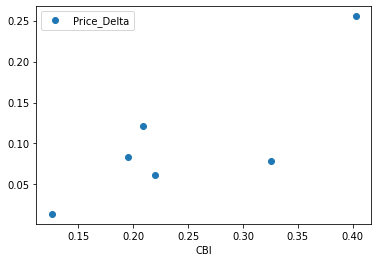

In [26]:
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500 = table[0]
print (sp500)
sp500 = sp500[['Symbol','Security','GICS Sector']]
# sp500 = sp500.head(5)

# filename = 'constituents_csv.csv'
# sp500 = pd.read_csv(filename)
sp500['CBI_RSI']= np.nan
sp500['CBI_SS']= np.nan
sp500['CBI_MACD']= np.nan
sp500['CBI'] = np.nan
sp500['t-30price'] = np.nan
sp500['Price_Delta'] = np.nan
sp500 = sp500[sp500['Symbol'] != "."]
# sp500 = sp500.head(100)

# sp500.groupby(['GICS Sector']).count()
# df2['CBI'] = CBI_func(df2['Symbol'],start_time,end_time)

# start_time = (datetime.datetime.now().date() - datetime.timedelta(days = 90)).isoformat()
# end_time = (datetime.datetime.now().date() - datetime.timedelta(days = 30)).isoformat()
print("Start Date: ", start_time)
print("End Date: ", end_time )

#
sector_list = list(sp500['GICS Sector'].unique())
#ticker_list = list(sp500['Symbol'])
passed_tickers=[]
no_data_tickers = []
for sector in sector_list:
    ticker_list = list(sp500[sp500['GICS Sector']==sector]['Symbol'])
    for ticker in ticker_list:
      try:
        CBIL = CBI_func(ticker, start_time, end_time)
        sp500.loc[sp500['Symbol'] == ticker, ['CBI_RSI','CBI_SS','CBI_MACD','CBI','t-30price','Price_Delta']] = [CBIL[0], CBIL[1], CBIL[2], sum(CBIL[0:2])/3.0,CBIL[3],CBIL[4]]
        if np.isnan(sum(CBIL[0:2])/3.0) == True:
          print('Analyzed Security: ',ticker, 'Failed')
          
        else: 
          print('Analyzed Security: ',ticker, 'Passed')
          passed_tickers.append(ticker)
      except:
        print('Analyzed Security: ',ticker, 'No Data')
        no_data_tickers.append(ticker)
        continue


#print("CBI = ", CBI_all)
print(sp500)
print('Tickers Qualified by CBI Criteria: ', passed_tickers)
print('Tickers for which data was not obtained: ', no_data_tickers)
sp500.plot(x='CBI',y='Price_Delta',style='o')

In [28]:
print(sp500[sp500['Symbol']=="AKAM"])


   Symbol             Security             GICS Sector   CBI_RSI    CBI_SS  CBI_MACD       CBI  t-30price  Price_Delta
13   AKAM  Akamai Technologies  Information Technology  0.362544  0.846309  0.195775  0.402951  95.940002     0.255368
